# Explaining the Titanic Dataset

In this tutorial, we will walk through the most basic process of getting a variety of different explanations for model predictions on a simple dataset, the Titanic dataset. We will see which features contribute most to survival predictions for passengers who were on board the Titanic.

### In this tutorial, you will learn...
1. How to use basic Pyreal transformers required to get data model-ready
2. How to use three basic types of Pyreal Explainers
3. How to use the `visualize` module to get simple visualizations of explanations

Data source:
Kaggle. (2012). Titanic: Machine Learning from Disaster. Retrieved from https://www.kaggle.com/c/titanic/data.


## Data Preparation

We will begin by loading the data, and writing out human-readable descriptions of all features. These descriptions will be used later to make the explanations provided more useful.

Our input data includes 11 features, each referring to one passenger who was on board the Titanic. The target variable we seek to predict is whether each passenger survived or not.

In [1]:
from sklearn.model_selection import train_test_split
from pyreal.sample_applications import titanic
import numpy as np

np.random.seed(1)

x_orig, y = titanic.load_data(include_targets=True)

x_train_orig, x_test_orig, y_train, y_test = train_test_split(x_orig, y, test_size=.20)

feature_descriptions = {
    "PassengerId": "Passenger ID",
    "Pclass": "Ticket Class",
    "SibSp": "Number of siblings/spouses aboard",
    "Parch": "Number of parents/children aboard",
    "Ticket": "Ticket Number",
    "Fare": "Passenger Fare",
    "Cabin": "Cabin Number",
    "Embarked": "Port of Embarkment",
}

x_train_orig.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
301,302,3,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q
309,310,1,"Francatelli, Miss. Laura Mabel",female,30.0,0,0,PC 17485,56.9292,E36,C
516,517,2,"Lemore, Mrs. (Amelia Milley)",female,34.0,0,0,C.A. 34260,10.5000,F33,S
120,121,2,"Hickman, Mr. Stanley George",male,21.0,2,0,S.O.C. 14879,73.5000,NaN,S
570,571,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.5000,NaN,S


## Pyreal Transformers

Transformers are an essential element in both training well-performing ML models and generating useful explanations of those model.

In the follow code block, we use three types of transformers:
1. A `ColumnDropTransformer`, which removes features that are not predictive when training the model. Pyreal will set the contributions/importance of these features to zero in any resulting explanation.
2. A `MultiTypeImputer`, which imputes missing data with the mean (for numeric columns) or mode (for categorical columns) value.
3. A `OneHotEncoder`, which one-hot encodes the two categorical input features to a set of Boolean columns. These columns will be aggregated back into their categorical formats in any resulting explanation.

We can use the Pyreal built-in functions `fit_transformers` and `run_transformers` to fit all transformers and apply their transforms to data (`fit_transformers` also returns the transformed data after fitting).

In [2]:
from pyreal.transformers import OneHotEncoder, ColumnDropTransformer, MultiTypeImputer
from pyreal.transformers import fit_transformers, run_transformers

column_drop = ColumnDropTransformer(["PassengerId", "Name", "Ticket", "Cabin"])
imputer = MultiTypeImputer()
one_hot_encoder = OneHotEncoder(["Sex", "Embarked"],)

transformers = [column_drop, imputer, one_hot_encoder]
x_transform_train = fit_transformers(transformers, x_train_orig)
x_transform_test = run_transformers(transformers, x_test_orig)

Now that we have our transformed data, we can train an ML model. Pyreal currently accepts models as objects with `.predict()` functions or filenames containing such objects in pickled format.

In [3]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=500)
model.fit(x_transform_train, y_train)

preds = model.predict(x_transform_test)
print("Test accuracy: %.2f" % (np.mean(preds==y_test)*100))

Test accuracy: 79.89


## Pyreal Explainers

Pyreal generates explanations using Explainer objects. In this tutorial, we will explore three simple explainers, that offer three types of explanations: local feature contributions, global feature importances, and surrogate decision trees.

We will begin by generating a local feature contribution explanation, which takes in one or more model inputs (ie, rows in a dataset). For each input, this explanation offers one positive or negative value per feature, representing how much that feature contributed to the final prediction for that input. See the example generated below for more information.

We can generate this explanation using a `LocalFeatureContribution` Explainer object. All Pyreal Explainers take in a model object (or a string representing a filename where a pickled model object is saved), a dataset, and a set of required transformers. Additionally, we can give Explainers a dictionary of feature descriptions, which is used to convert the data column names to readable names. Finally, we will set the `fit_on_init` parameter to True, to indicate that we'd like to fit our Explainer to the provided data right away.

Explainers can be used to easily get the model's prediction on inputs, automatically applying all necessary transformations. In this case, we can see using the `model_predict` method that a certain sample passeneger did survive the sinking of the titanic.

We can then use the `.produce()` method to explain why the model predicts this passenger survived.

In [4]:
from pyreal.explainers import LocalFeatureContribution

lfc = LocalFeatureContribution(model=model, x_train_orig=x_train_orig, transformers=transformers,
                               feature_descriptions=feature_descriptions, fit_on_init=True)

sample_passenger = x_test_orig.iloc[0]
survived = lfc.model_predict(sample_passenger)
print("The sample passenger survived") if survived else print("The sample passenger did not survive")

explanation = lfc.produce(sample_passenger)

The sample passenger survived


## Pyreal Visualization

Pyreal offers a few functions to help visualize the generated explanations, found in the `visualize` module. We can use the `plot_top_contributors` function to visualize the contributions generated in the previous cell. We set `select_by` to absolute to indicate that we'd like to see the features that contributed to most to the final prediction of `input_to_explain`, either positively or negatively.

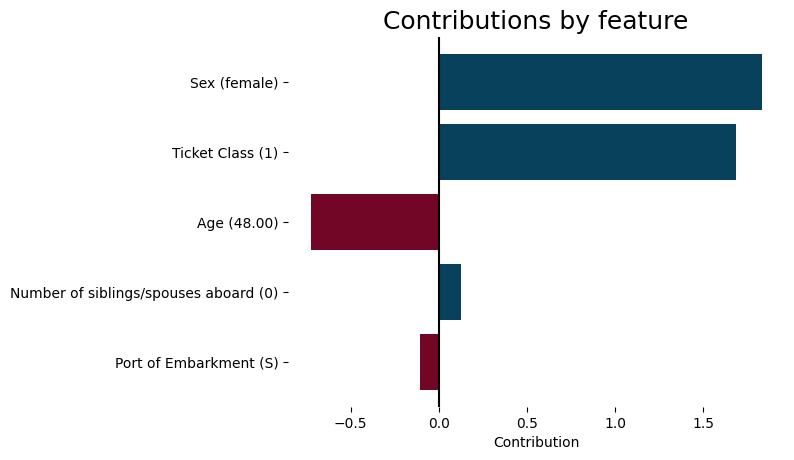

In [5]:
from pyreal import visualize

visualize.plot_top_contributors(explanation, select_by="absolute", show=True)

As we can see in the generated visualization, the fact that this passenger was female and in first class greatly increased the passenger's chance of surviving the sinking of the titanic. In contrast, the age of the passenger decreased her chance of survival.

## Generating alternative explanation types

We can easily switch to a different explanation type by using a differenet type of Pyreal Explainer. Let's try using a global feature importance explanation, which provides a positive value for each feature, representing its overall importance to the model's predictions. This way, we can see if - for example - sex and class are always important features, or if this was the case only for our sample passenger.

To generate this kind of explanation, we use a `GlobalFeatureImportance` Explainer.

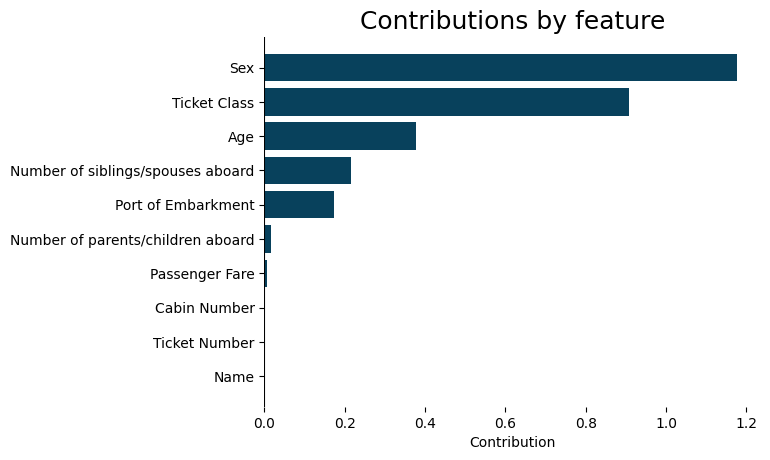

In [6]:
from pyreal.explainers import GlobalFeatureImportance

gfi = GlobalFeatureImportance(model=model, x_train_orig=x_train_orig,
                              transformers=transformers,
                              feature_descriptions=feature_descriptions, fit_on_init=True)

importances = gfi.produce()

visualize.plot_top_contributors(importances, select_by="absolute", show=True, n=10)


We can see that overall, for all passengers, the model tends to heavily use features such as the sex and ticket class of the passenger relatively more, while factoring in features such a the family on board less. Cabin number, ticket number, and passenger name are not used at all by the model (in fact, we intentionally excluded these features using the `ColumnDropTransformer`).

The final kind of Explainer we will demonstrate in this tutorial is the `DecisionTreeExplainer`, which attempts to represent the original model as a decision tree model. When kept to a reasonable size, decision tree models can be fairly interpretable, as you can follow their decision-making process down the tree.

Once again, all we need to do to get the new explanation type is change the Explainer call.

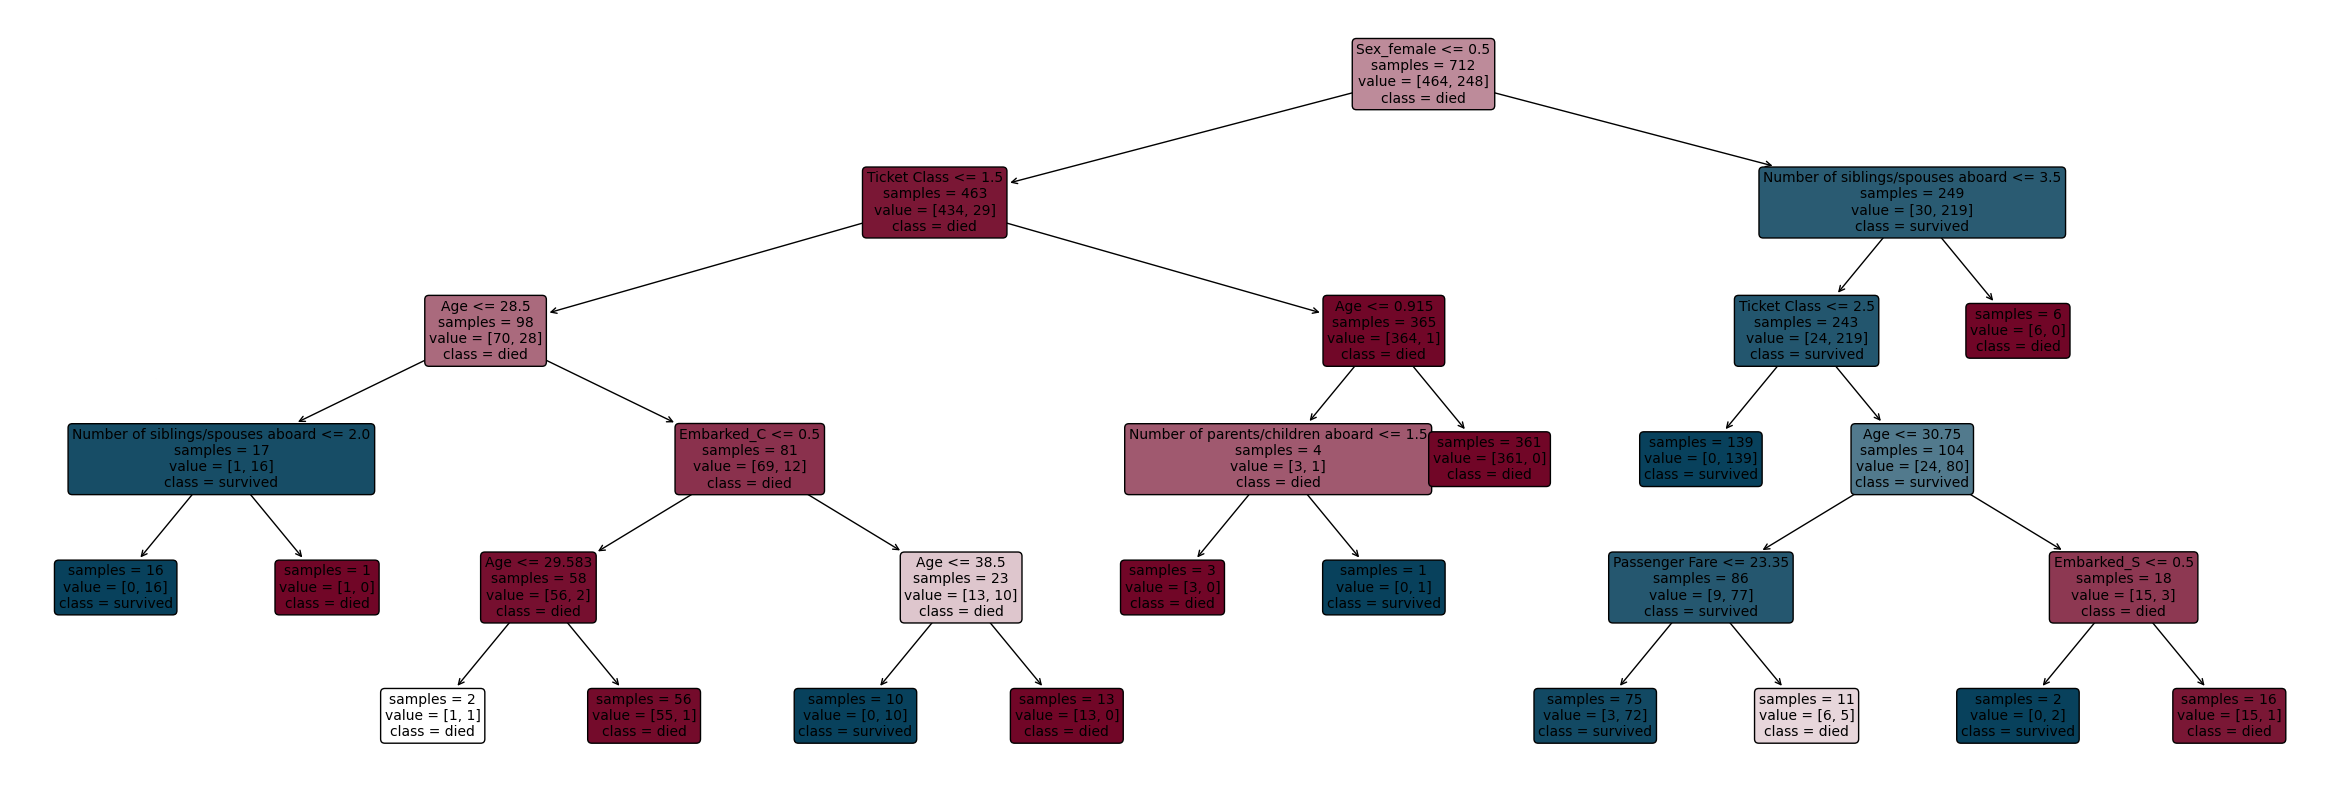

In [7]:
from pyreal.explainers import DecisionTreeExplainer
from pyreal.visualize import plot_tree_explanation

dte = DecisionTreeExplainer(model=model, x_train_orig=x_train_orig, is_classifier=True, max_depth=5,
                            transformers=transformers,
                            feature_descriptions=feature_descriptions, fit_on_init=True)

decision_tree = dte.produce()

plot_tree_explanation(dte, class_names=["died", "survived"],
                      impurity=False, fontsize=10, filled=True)